# Notes from *Regression and Other Stories* chapter 13

In [1]:
import math

import arviz as az
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library("arm")
library("foreign")
library("rstanarm")

Loading required package: MASS
Loading required package: Matrix
Loading required package: lme4

arm (Version 1.12-2, built: 2021-10-15)

Working directory is /home/jovyan/RegressionAndOtherStories

Loading required package: Rcpp
This is rstanarm version 2.21.1
- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!
- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.
- For execution on a local, multicore CPU with excess RAM we recommend calling
  options(mc.cores = parallel::detectCores())

Attaching package: ‘rstanarm’

The following objects are masked from ‘package:arm’:

    invlogit, logit



## Logistic regression with a single predictor

Load the elections dataset

In [4]:
%%R

nes <- read.table("ROS-Examples/NES/data/nes.txt", header=TRUE)

In [5]:
%%R
nes92 <- nes[nes$year == 1992,]

In [6]:
nes = pd.read_csv("ROS-Examples/NES/data/nes.txt", sep=" ")
nes92 = nes.loc[nes.year == 1992,:].dropna(subset=['rvote','income']).reset_index(drop=True)

Fit a basic model

In [7]:
%%R
sink(".Rout.tmp")
fit1 = stan_glm(rvote ~ income, family=binomial(link=logit), data=nes92)
sink()

In [8]:
%%R
print(fit1)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income
 observations: 1356
 predictors:   2
------
            Median MAD_SD
(Intercept) -1.4    0.2  
income       0.3    0.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [9]:
nes['income'].describe()

count    34908.000000
mean         2.933196
std          1.144127
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: income, dtype: float64

In [10]:
nes.head()

,year,resid,weight1,weight2,weight3,age,gender,race,educ1,urban,...,parent_party,white,year_new,income_new,age_new,vote.1,age_discrete,race_adj,dvote,rvote
536,1952,1,1.0,1.0,1.0,25,2,1,2,2.0,...,2.0,1,1,1,-2.052455,1.0,1,1.0,0.0,1.0
537,1952,2,1.0,1.0,1.0,33,2,1,1,2.0,...,0.0,1,1,1,-1.252455,1.0,2,1.0,1.0,0.0
538,1952,3,1.0,1.0,1.0,26,2,1,2,2.0,...,-2.0,1,1,0,-1.952455,1.0,1,1.0,0.0,1.0
539,1952,4,1.0,1.0,1.0,63,1,1,2,2.0,...,NaN,1,1,0,1.747545,1.0,3,1.0,0.0,1.0
540,1952,5,1.0,1.0,1.0,66,2,1,2,2.0,...,-2.0,1,1,-2,2.047545,1.0,4,1.0,0.0,1.0


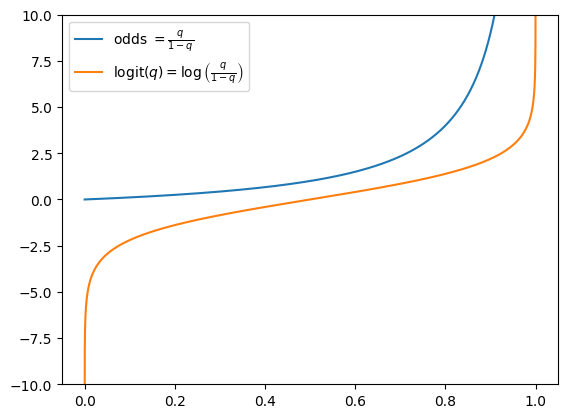

In [11]:
x = np.linspace(1e-16, 1 - 1e-16, 10000)
plt.plot(x, x / (1 - x), label=r"odds $= \frac{q}{1-q}$")
plt.plot(x, sp.special.logit(x),
         label=r"$\mathrm{logit}(q) = \log\left(\frac{q}{1-q}\right)$")
plt.ylim((-10,10))
plt.legend()
plt.savefig('logit_and_odds.pdf')

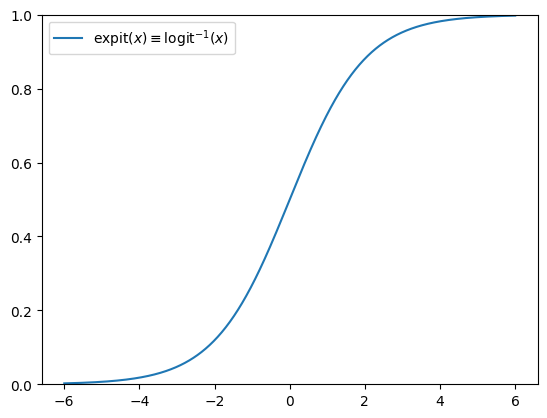

In [12]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x),
         label=r"$\text{expit}(x) \equiv \text{logit}^{-1}(x)$")
plt.ylim((0,1))
plt.legend()
#plt.savefig('expit.pdf')

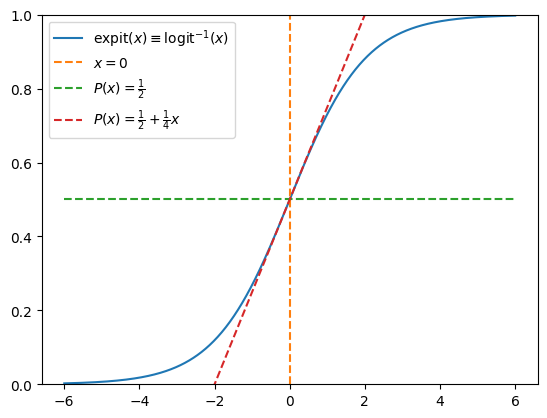

In [13]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x),
         label=r"$\text{expit}(x) \equiv \text{logit}^{-1}(x)$")
plt.plot((0,0), (0,1), '--', label=r"$x = 0$")
plt.plot((-6,6), (0.5,0.5), '--', label=r"$P(x) = \frac{1}{2}$")
plt.plot(x, x/4 + 0.5, '--', label=r"$P(x) = \frac{1}{2} + \frac{1}{4}x$")
plt.ylim((0,1))
plt.legend()
#plt.savefig('expit_taylor.pdf')

$$
\mathrm{logit}(q) \equiv \log\left(\frac{q}{1-q}\right)
$$

Assume $q \in \mathbb{R}$, $0 < q < 1$. Then let
$$
\begin{align}
x &= \mathrm{logit}(q) \\
  &= \log\left(\frac{q}{1-q}\right) \\
&\Rightarrow e^x = \frac{q}{1-q} \\
&\Rightarrow e^x - q e^x = q \\
&\Rightarrow 1 - q = q e^{-x} \\
&\Rightarrow 1 = q + q e^{-x} \\
&\Rightarrow \frac{1}{1 + e^{-x}} = q.
\end{align}
$$
Therefore
$$
\text{logit}^{-1}(x) \equiv \mathrm{expit}(x) = \frac{1}{1 + e^{-x}}
    = \frac{e^x}{1 + e^{x}}.
$$
Note that
$$
\text{expit}(0) = \frac{e^0}{1 + e^0} = \frac{1}{2}
$$

$$
\begin{align}
\frac{d}{dx}\left(\text{expit}(x)\right) &= \frac{d}{dx}\left(\frac{1}{1 + e^{-x}}\right) \\
 &= \frac{d}{dx}\left((1 + e^{-x})^{-1}\right) \\
 &= \left(\frac{d}{dx}(1 + e^{-x})\right)\left(-(1 + e^{-x})^{-2}\right) \\
 &= e^{-x} (1 + e^{-x})^{-2} \\
 &= (1 + e^{-x} - 1)(1 + e^{-x})^{-2} \\
 &= \frac{1 + e^{-x} - 1}{1 + e^{-x}} \cdot \frac{1}{1 + e^{-x}} \\
 &= \left(
     \frac{1 + e^{-x}}{1 + e^{-x}} - \frac{1}{1 + e^{-x}}
     \right) \frac{1}{1 + e^{-x}} \\
 &= \left(1 - \text{expit}(x)\right)\;\text{expit}(x).
\end{align}
$$

Note that
$$
\begin{align}
\left.\left(\frac{d}{dx}\text{expit}(x)\right)\right|_{x=0}
 &= \left(1 - \text{expit}(0)\right)\;\text{expit}(0) \\
 &= \left(1 - \frac{1}{2}\right)\;\frac{1}{2} \\
 &= \frac{1}{4}.
\end{align}
$$

Also observe that

$$
\begin{align}
\frac{d^2}{dx^2}\left(\text{expit}(x)\right)
    &= \frac{d}{dx}\Bigl(
        \bigl(1 - \text{expit}(x)\bigr)\;\text{expit}(x)
    \Bigr) \\
    &= \frac{d}{dx}\bigl(
        \text{expit}(x) - \text{expit}^2(x)
    \bigr) \\
    &= \frac{d}{dx}\biggl(
        \bigl(1 - \text{expit}(x)\bigr)\;\text{expit}(x)
        - 2 \Bigl(\bigl(1 - \text{expit}(x)\bigr)\;\text{expit}(x) \Bigr)
        \text{expit}(x)
    \biggr) \\
    &= \bigl(1 - \text{expit}(x)\bigr)\;\text{expit}(x)
        - 2 \Bigl(\bigl(1 - \text{expit}(x)\bigr)\;\text{expit}(x) \Bigr)
        \text{expit}(x) \\
    &= \text{expit}(x) - 3\;\text{expit}^2 (x) + 2\;\text{expit}^3(x)
\end{align}
$$

and
$$
\begin{align}
\left.\left(\frac{d^2}{dx^2}\text{expit}(x)\right)\right|_{x=0}
 &= \text{expit}(x) - 3\;\text{expit}^2 (x) + 2\;\text{expit}^3(x) \\
 &= \frac{1}{2} - \frac{3}{2^2} + \frac{2}{2^3} \\
 &= \frac{2}{4} - \frac{3}{4} + \frac{1}{4} \\
 &= 0.
\end{align}
$$

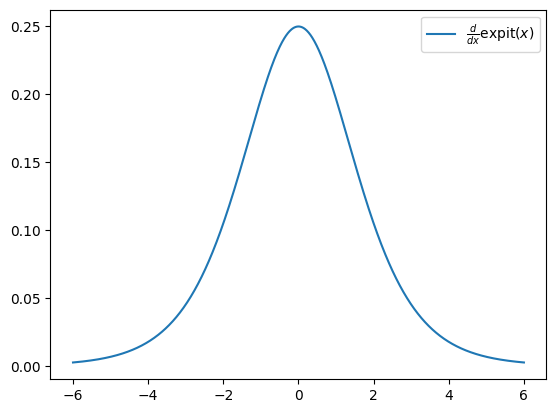

In [14]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x) * (1 - sp.special.expit(x)),
         label=r"$\frac{d}{dx}\text{expit}(x)$")
plt.legend()
#plt.savefig('expit_derivative.pdf')

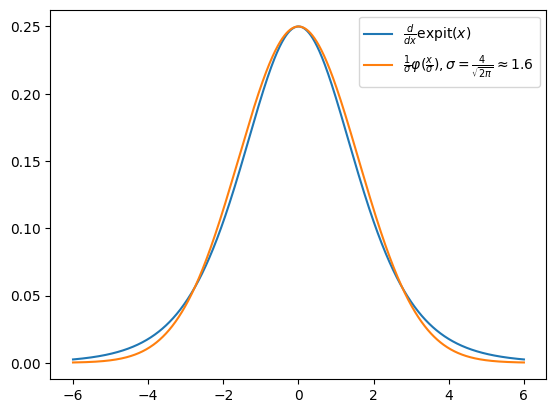

In [15]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x) * (1 - sp.special.expit(x)),
         label=r"$\frac{d}{dx}\text{expit}(x)$")
sigma = 4/math.sqrt(2*math.pi)
plt.plot(x, 1/sigma * sp.stats.norm.pdf(x/sigma),
        label=r"$\frac{1}{\sigma}\varphi(\frac{x}{\sigma}),"
         + r"\sigma=\frac{4}{\sqrt{2 \pi}}\approx 1.6$")
plt.legend()
#plt.savefig('normal_and_expit_derivative.pdf')

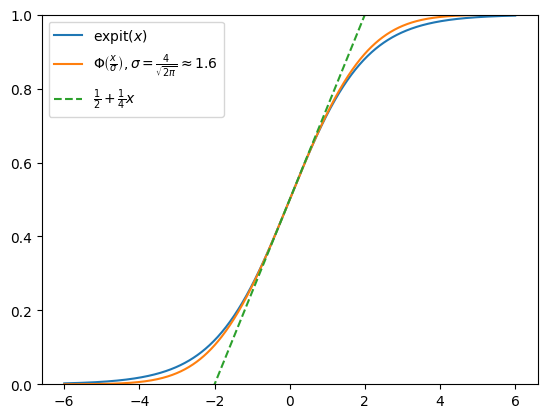

In [16]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x),
         label=r"$\text{expit}(x)$")
plt.plot(x, 1/2*(1 + sp.special.erf((x/1.6)/2**0.5)),
         label=r"$\Phi\left(\frac{x}{\sigma}\right),"
         + r"\sigma=\frac{4}{\sqrt{2 \pi}}\approx 1.6$")
plt.plot(x, x/4 + 0.5, '--', label=r"$\frac{1}{2} + \frac{1}{4}x$")
plt.ylim(0,1)
plt.legend()
#plt.savefig('expit_erf_aligned.pdf')

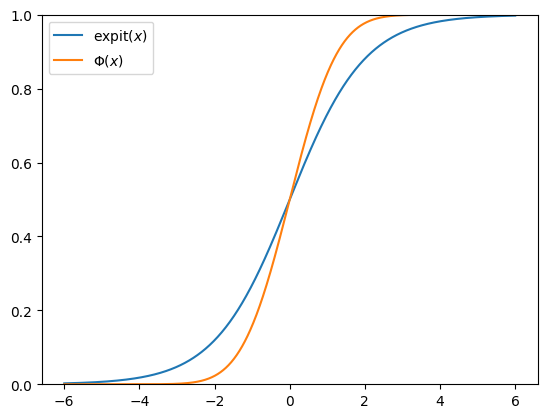

In [17]:
x = np.linspace(-6, 6, 1000)
plt.plot(x, sp.special.expit(x),
         label=r"$\text{expit}(x)$")
plt.plot(x, 1/2*(1 + sp.special.erf((x)/2**0.5)),
         label=r"$\Phi\left(x\right)$")
plt.ylim(0,1)
plt.legend()
#plt.savefig('expit_and_erf.pdf')

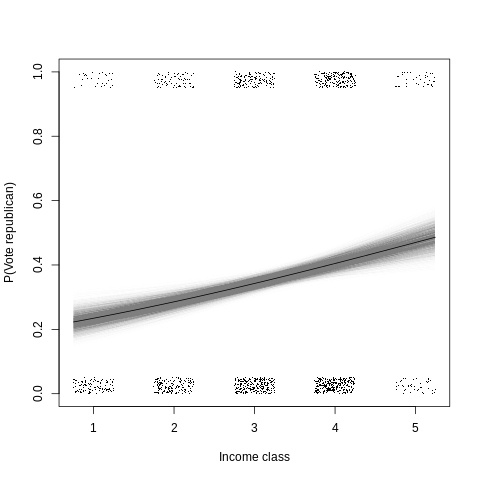

In [18]:
%%R
eta1 = 0.5*(runif(dim(nes92)[1]) - 0.5)
eta2 = 0.1*(runif(dim(nes92)[1]))

# pdf("fig13_2.pdf", width = 8, height = 6)

plot(nes92$income + eta1, 
     nes92$rvote + (0.5 - nes92$rvote)*eta2,
     xlab='Income class',
     ylab='P(Vote republican)',
     pch='.')

sims1 = as.matrix(fit1)
for (j in 1:nrow(sims1)) {
    curve(invlogit(sims1[j,1] + sims1[j,2]*x),
          col=rgb(0,0,0,alpha=0.005), add=TRUE, lwd=1)
}

curve(invlogit(coef(fit1)[1] + coef(fit1)[2]*x), add=TRUE, lwd=1)

# dev.off()

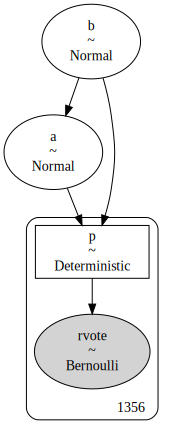

In [19]:
model = pm.Model()

with model:
    # priors
    b = pm.Normal("b", mu=0, sigma=2.5/nes92['income'].std())
    a = pm.Normal("a", mu=-b*nes92['income'].mean(), sigma=2.5)
    # linear model
    mu = a + b * nes92['income'].astype(float)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("rvote", p=p, observed=nes92['rvote'])

plot = pm.model_to_graphviz(model)
#plot.render('fig13_graphviz.dot', format='pdf')
plot

In [20]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


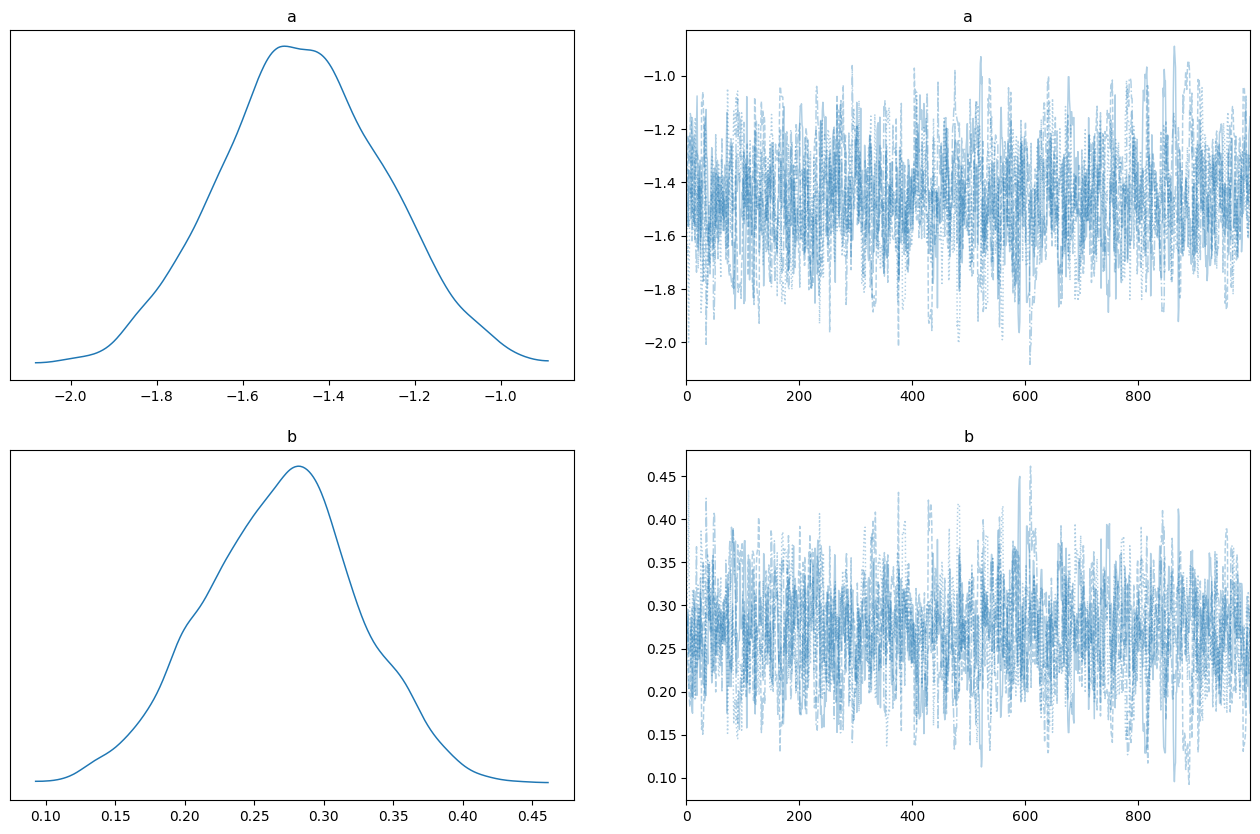

In [21]:
az.plot_trace(idata, combined=True, var_names=["a","b"], figsize=(16,10));
#plt.savefig("fig13_pymc.pdf")

In [22]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.27,0.06,0.16,0.37,0.00,0.0,806.99,942.73,1.0
a,-1.46,0.19,-1.84,-1.12,0.01,0.0,806.00,919.37,1.0
p[0],0.41,0.02,0.37,0.44,0.00,0.0,2028.07,2600.27,1.0
p[1],0.28,0.02,0.25,0.32,0.00,0.0,1010.25,1479.23,1.0
p[2],0.23,0.02,0.19,0.28,0.00,0.0,843.84,1030.09,1.0
...,...,...,...,...,...,...,...,...,...
p[1351],0.28,0.02,0.25,0.32,0.00,0.0,1010.25,1479.23,1.0
p[1352],0.23,0.02,0.19,0.28,0.00,0.0,843.84,1030.09,1.0
p[1353],0.41,0.02,0.37,0.44,0.00,0.0,2028.07,2600.27,1.0
p[1354],0.34,0.01,0.32,0.37,0.00,0.0,2546.80,2881.58,1.0


In [23]:
a_samples = idata.posterior["a"].to_numpy().flatten()
b_samples = idata.posterior["b"].to_numpy().flatten()

Text(0, 0.5, 'Pr(Republican vote)')

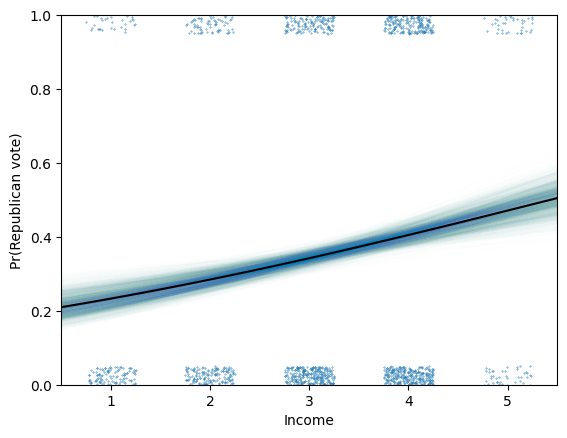

In [24]:
eta1 = np.random.uniform(-0.25, 0.25, nes92['income'].shape[0])
eta2 = np.random.uniform(0, 0.1, nes92['income'].shape[0])
plt.scatter(
    nes92['income'] + eta1, 
    nes92['rvote'] + (0.5 - nes92['rvote'])*eta2,
    s=0.1,
)
u = np.linspace(0,6,100)
num_samples = 1000
for i in range(num_samples):
    plt.plot(u, sp.special.expit(u*b_samples[i] + a_samples[i]), color=(0,0.5,0.7), alpha=1/128)

plt.plot(u, sp.special.expit(u*b_samples.mean() + a_samples.mean()), color="black")
plt.xlim((0.5, 5.5))
plt.ylim(0,1)
plt.xlabel("Income")
plt.ylabel("Pr(Republican vote)")
#plt.savefig('fig13_2_py.pdf')

Text(0, 0.5, 'Pr(Republican vote)')

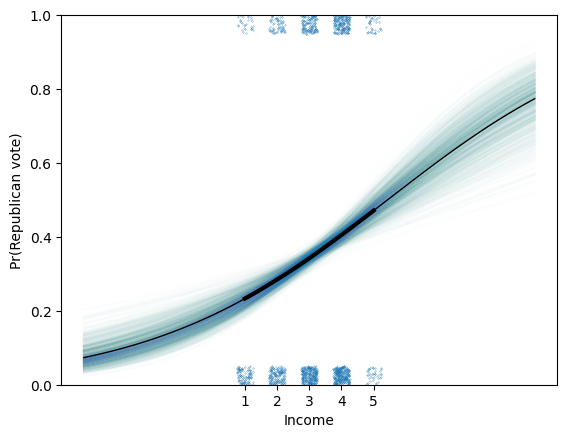

In [25]:
eta1 = np.random.uniform(-0.25, 0.25, nes92['income'].shape[0])
eta2 = np.random.uniform(0, 0.1, nes92['income'].shape[0])
plt.scatter(
    nes92['income'] + eta1, 
    nes92['rvote'] + (0.5 - nes92['rvote'])*eta2,
    s=0.05,
)
u = np.linspace(-4,10,100)
v = np.linspace(1, 5, 100)
num_samples = 1000
for i in range(num_samples):
    plt.plot(u, sp.special.expit(u*b_samples[i] + a_samples[i]), color=(0,0.5,0.7), alpha=1/128)

plt.plot(v, sp.special.expit(v*b_samples.mean() + a_samples.mean()), color="black", linewidth=3)
plt.plot(u, sp.special.expit(u*b_samples.mean() + a_samples.mean()), color="black", linewidth=1)
#plt.xlim((0.5, 5.5))
plt.ylim(0,1)
plt.xticks(range(1,6))
plt.xlabel("Income")
plt.ylabel("Pr(Republican vote)")
#plt.savefig('fig13_2_wide_py.pdf')

In [26]:
median_a = np.quantile(a_samples, 0.5)
median_a

-1.4621487525604775

In [27]:
mad_a = np.abs(a_samples - a_samples.mean()).mean()
mad_a

0.15287600642817598

In [28]:
mad_sd_a = mad_a/sp.stats.norm.ppf(0.75)
mad_sd_a

0.22665430628669037

In [29]:
median_b = np.quantile(b_samples, 0.5)
median_b

0.27122570654494416

In [30]:
mad_b = np.abs(b_samples - b_samples.mean()).mean()
mad_b

0.044888848190788165

In [31]:
mad_sd_b = mad_b/sp.stats.norm.ppf(0.75)
mad_sd_b

0.0665523059138237